In [171]:
# oimization ideas:
# 	* find the furthest red pixels up down left right and do the rolling window only there to find if there is a sign
# 	* don't check for every single pixel in shape, rather choose a relevant number of pixels to check and only check that many (
# 		- eg: check every other pixel for a 200 by 200 pixel sign
#       - do a maximum of 1% culling and show at max one at every 10 px on OX and one in every 10 on OY. Balance the values to be 3:2 instead of 6:1


# current best strategy:   
#   * find all red chunks in immage
#   * think of every chunk as a give way sign with:
#       - side starting in the top left highest red pixel and ending in the top right red pixel
#       - and height startign in the lowest red piexel and ending in the perpendicular highest red pixel above
#   * account for rotation and for squishing in the immage
#   * try to get width of the red triangle in pixels and adjust in the funciton

# optimisations:
#   * check only a percentage of pixels
#   * when looking for a chunk stop if found and then not found

In [172]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from dataclasses import dataclass

In [173]:
DATA_DIR = "./my-dataset"
GIVE_WAY_DIR = os.path.join(DATA_DIR, "give-way")

RED_PX = 0
GREEN_PX = 1
BLUE_PX = 2

In [174]:
# useful structs

@dataclass
class point:
    x: float
    y: float

@dataclass 
class give_way_chunk:
    top_left_point:  point
    top_right_point: point 
    bottom_point:    point

    side_length:     float
    height_length:   float
    rotation_deg:    float

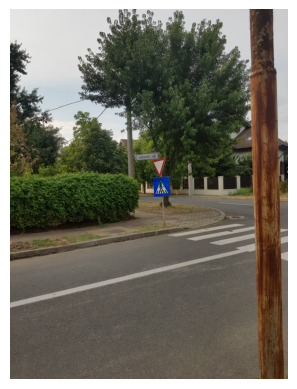

In [175]:
# print a picture

gw_images = []
for img_name in sorted(os.listdir(GIVE_WAY_DIR)):
    gw_images.append(np.transpose(mpimg.imread(os.path.join(GIVE_WAY_DIR, img_name)), (1, 0, 2)))
    
test_img = gw_images[3]

plt.imshow(test_img)
plt.axis('off')
plt.show()

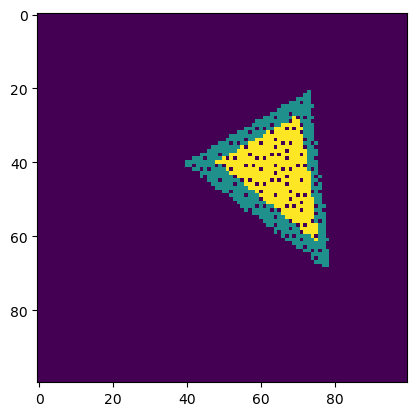

In [176]:
# draw a black and white give way sign of arbitrary size, only draw a portion of the pixels

def between(p_val, p_lower, p_higher):
    return p_val <= p_higher and p_val >= p_lower

def area(p_x1, p_y1, p_x2, p_y2, p_x3, p_y3):
    return np.abs(p_x1*(p_y2-p_y3) + p_x2*(p_y3-p_y1) + p_x3*(p_y1-p_y2)) / 2.0

def in_triangle(p_x, p_y, p_x1, p_y1, p_x2, p_y2, p_x3, p_y3):
    margin_of_error = 0.001

    A = area(p_x1, p_y1, p_x2, p_y2, p_x3, p_y3)

    A1 = area(p_x, p_y, p_x2, p_y2, p_x3, p_y3)
    A2 = area(p_x1, p_y1, p_x, p_y, p_x3, p_y3)
    A3 = area(p_x1, p_y1, p_x2, p_y2, p_x, p_y)

    area_sum = A1 + A2 + A3

    return (A <= area_sum + margin_of_error * area_sum) and (A >= area_sum - margin_of_error * area_sum)


def drawSign(p_mat, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
    p_angle = p_angle * np.pi/180
    height_factor = 1

    equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
    if p_height != -1:
        height_factor = p_height / equilateral_height
    else:
        p_height = equilateral_height

    red_tiangle_height = int(equilateral_height * height_factor) 
    converging_factor = 2 / np.sqrt(3) / height_factor # math :)

    shape_area = red_tiangle_height * p_side / 2
    pixels_to_check = 1 * shape_area

    px_culling_rate = 1

    if shape_area > pixels_to_check:
        px_culling_rate =  pixels_to_check / shape_area 
    
    red_band_width = 0.1 * p_side

    for i in range(p_y_start, p_y_start + red_tiangle_height):
        for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
            x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
            y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

            if(np.random.rand() <= px_culling_rate):

                left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
                right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
                bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

                left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
                                    p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
                                    
                right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
                                    p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

                bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
                                    p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

                if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
                    p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)] = 20
                else:
                    p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)] = 10


# matrix = np.zeros((20, 20))
# drawSign(matrix, 1, 6, 10)
# plt.imshow(matrix)

matrix = np.zeros((100, 100))
drawSign(matrix, 40, 40, 40, 45, -30)
plt.imshow(matrix)

# matrix = np.zeros((1000, 1000))
# drawSign(matrix, 300, 200, 500)
# plt.imshow(matrix)

[229 231 228]


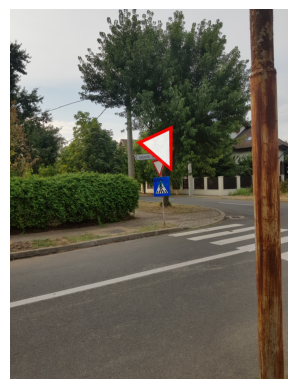

In [177]:
# print a generated give way sign on a immage
def drawRgbSign(p_mat, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
	height_factor = 1

	equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
	if p_height != -1:
		height_factor = p_height / equilateral_height
	else:
		p_height = equilateral_height

	red_tiangle_height = int(equilateral_height * height_factor) 
	converging_factor = 2 / np.sqrt(3) / height_factor # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = 1 * shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
	
	red_band_width = 0.08 * p_side

	for i in range(p_y_start, p_y_start + red_tiangle_height):
		for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
			x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
			y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

			if(np.random.rand() <= px_culling_rate):

				left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
				right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
				bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

				left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
									
				right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

				bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

				if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
					for pixel in range(0, 3):
						p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][pixel] = 255
				else:
					p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][RED_PX] = 255
					p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][GREEN_PX] = 0
					p_mat[(p_y_start + y_rotation)][(p_x_start + x_rotation)][BLUE_PX] = 0

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

drawRgbSign(img, 1372, 1453, 440, 460, -25 * np.pi / 180)

plt.imshow(img)
plt.axis('off')
plt.show()

[229 231 228]


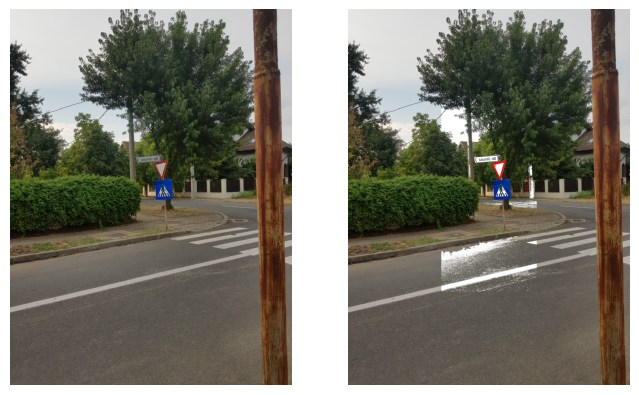

In [178]:
# find treshold values in order to correctly identify white and red

def is_red(p_matrix_px):
    return (int(p_matrix_px[RED_PX]) > 2 * int(p_matrix_px[GREEN_PX]) and int(p_matrix_px[RED_PX]) > 2 * int(p_matrix_px[BLUE_PX]))

def is_white(p_matrix_px):
    pixel_RGB_variance = 20
    minimum_red_brightness = 110

    return  (int(p_matrix_px[RED_PX]) + pixel_RGB_variance > int(p_matrix_px[GREEN_PX]) and\
            int(p_matrix_px[RED_PX]) - pixel_RGB_variance < int(p_matrix_px[GREEN_PX]) and\
            int(p_matrix_px[RED_PX]) + pixel_RGB_variance > int(p_matrix_px[BLUE_PX]) and\
            int(p_matrix_px[RED_PX]) - pixel_RGB_variance < int(p_matrix_px[BLUE_PX]) and\
            p_matrix_px[RED_PX] > minimum_red_brightness)

def check_red(p_img):
    trim = 1000

    for i in range(trim, len(p_img) - trim):
        for j in range(trim, len(p_img[0]) - trim):
            if is_red(p_img[i][j]):
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 0
                p_img[i][j][BLUE_PX] = 0

            if is_white(p_img[i][j]): 
                p_img[i][j][RED_PX] = 255
                p_img[i][j][GREEN_PX] = 255 
                p_img[i][j][BLUE_PX] = 255 

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

check_red(img)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(test_img)

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')
plt.show()

In [179]:
def check_for_sign(p_img, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
	red_band_width = 0.08 * p_side

	color_score = 0
	p_angle = p_angle * np.pi/180
	height_factor = 1

	equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
	if p_height != -1:
		height_factor = p_height / equilateral_height
	else:
		p_height = equilateral_height

	red_tiangle_height = int(equilateral_height * height_factor) 
	converging_factor = 2 / np.sqrt(3) / height_factor # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = 1 * shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
	

	for i in range(p_y_start, p_y_start + red_tiangle_height):
		for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
			x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
			y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

			if(np.random.rand() <= px_culling_rate):

				left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
				right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
				bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

				left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
									
				right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

				bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

				if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
					
					if is_white(p_img[(p_y_start + y_rotation)][(p_x_start + x_rotation)]):
						color_score += 1
				else:
					if is_red(p_img[(p_y_start + y_rotation)][(p_x_start + x_rotation)]):
						color_score += 1

	return  color_score / pixels_to_check



[229 231 228]


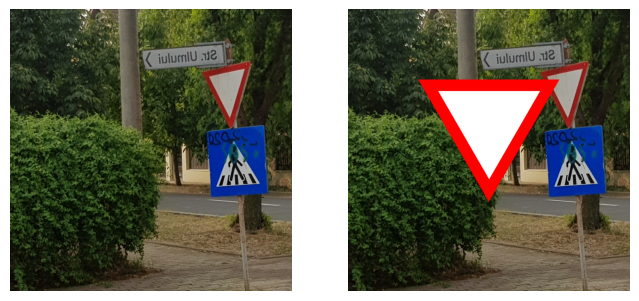

0.015998568360773086


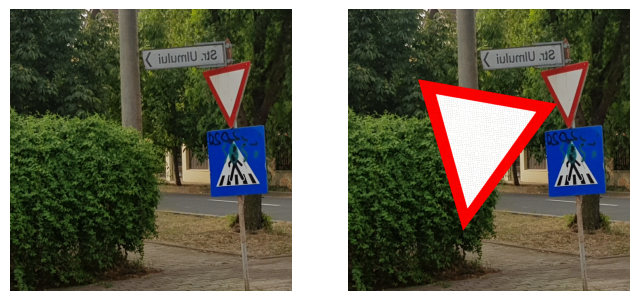

0.006115702479338843


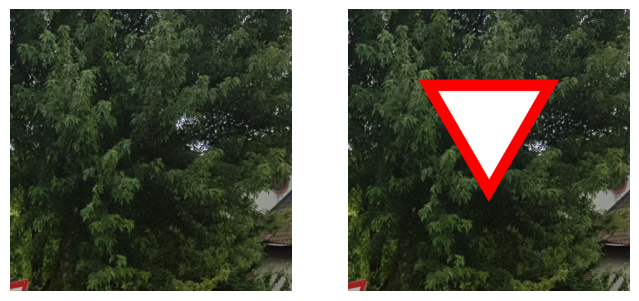

0.005141970890002386


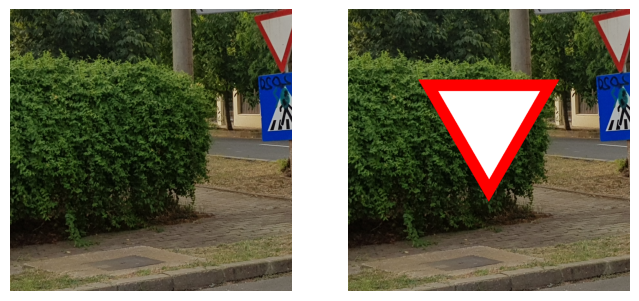

0.0


In [180]:
# funciton used to score how close a triangle of side p_side starting at x and y resemples a give way sign

def check_for_sign_with_print(p_img, p_x_start, p_y_start, p_side, p_height = -1, p_angle = 0):
	red_band_width = 0.08 * p_side

	color_score = 0
	p_angle = p_angle * np.pi/180
	height_factor = 1

	equilateral_height = int(np.sqrt(3 * p_side * p_side /4))
	if equilateral_height == 0:
		return
		
	if p_height != -1:
		height_factor = p_height / equilateral_height
	else:
		p_height = equilateral_height

	red_tiangle_height = int(equilateral_height * height_factor) 
	converging_factor = 2 / np.sqrt(3) / height_factor # math :)

	shape_area = red_tiangle_height * p_side / 2
	pixels_to_check = 1 * shape_area

	px_culling_rate = 1

	if shape_area > pixels_to_check:
		px_culling_rate =  pixels_to_check / shape_area 
	

	for i in range(p_y_start, p_y_start + red_tiangle_height):
		for j in range(int(p_x_start + ((i - p_y_start)/2) * converging_factor), int(p_x_start + p_side - (i - p_y_start) / 2 * converging_factor)):
			x_rotation = int((j - p_x_start) * np.cos(p_angle) - (i - p_y_start) * np.sin(p_angle))
			y_rotation = int((j - p_x_start) * np.sin(p_angle) + (i - p_y_start) * np.cos(p_angle))

			if(np.random.rand() <= px_culling_rate):

				left_pt = point(p_x_start + red_band_width * np.sqrt(3), p_y_start + red_band_width)
				right_pt = point(p_x_start + p_side - red_band_width * np.sqrt(3), p_y_start + red_band_width)
				bottom_pt = point(p_x_start + p_side/2, p_y_start + p_height - 2 * red_band_width)

				left_pt_rot = point(p_x_start + ((left_pt.x - p_x_start) * np.cos(p_angle) - (left_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((left_pt.x - p_x_start) * np.sin(p_angle) + (left_pt.y - p_y_start) * np.cos(p_angle)))
									
				right_pt_rot = point(p_x_start + ((right_pt.x - p_x_start) * np.cos(p_angle) - (right_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((right_pt.x - p_x_start) * np.sin(p_angle) + (right_pt.y - p_y_start) * np.cos(p_angle)))

				bottom_pt_rot = point(p_x_start + ((bottom_pt.x - p_x_start) * np.cos(p_angle) - (bottom_pt.y - p_y_start) * np.sin(p_angle)), 
									p_y_start + ((bottom_pt.x - p_x_start) * np.sin(p_angle) + (bottom_pt.y - p_y_start) * np.cos(p_angle)))

				if in_triangle(p_x_start + x_rotation, p_y_start + y_rotation, left_pt_rot.x, left_pt_rot.y, right_pt_rot.x, right_pt_rot.y, bottom_pt_rot.x, bottom_pt_rot.y):                  
					
					if is_white(p_img[(p_y_start + y_rotation)][(p_x_start + x_rotation)]):
						color_score += 1
				else:
					if is_red(p_img[(p_y_start + y_rotation)][(p_x_start + x_rotation)]):
						color_score += 1

	plt.figure(figsize=(8, 4))
	plt.subplot(1, 2, 1)
	plt.axis('off')

	border_width = int(p_side / 2)
	plt.imshow(p_img[(p_y_start - border_width):(p_y_start+p_side + border_width), (p_x_start - border_width):(p_x_start+p_side + border_width)])
	
	ideal_sign = p_img[(p_y_start - border_width):(p_y_start+p_side + border_width), (p_x_start - border_width):(p_x_start+p_side + border_width)].copy() 

	drawRgbSign(ideal_sign, border_width, border_width, p_side, red_tiangle_height, p_angle)
	plt.subplot(1, 2, 2)
	plt.axis('off')
	plt.imshow(ideal_sign)

	plt.show()

	return  color_score / pixels_to_check

np.shape(test_img)
len(test_img[0])
print(test_img[0][0])
img = test_img.copy()

# drawRgbSign(imgu, 0, 1853, 440)
x_val = 1160
y_val = 1680
side = 440

good_score = check_for_sign_with_print(test_img, x_val, y_val, side)
print(good_score)

good_score = check_for_sign_with_print(test_img, x_val, y_val, side, side, 10)
print(good_score)

bad_score = check_for_sign_with_print(test_img, 1853, 1000, 440)
print(bad_score)

bad_score = check_for_sign_with_print(test_img, 1000, 1853, 440)
print(bad_score)




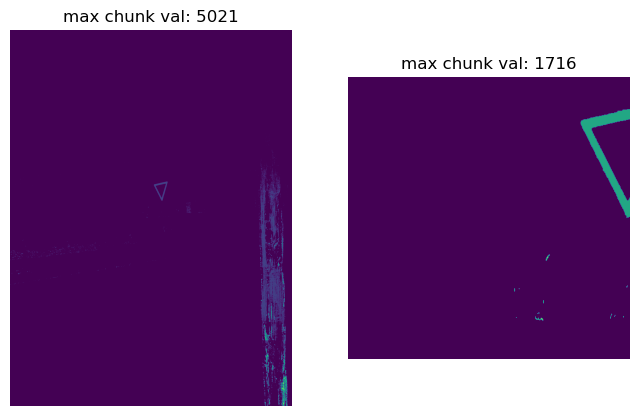

In [181]:
# find red chunks and separate them by labling

import sys
sys.setrecursionlimit(200000)  # Increase limit as needed

def fill_in_shape_recursive(p_img, p_label_mat, p_label, p_x, p_y):
    if p_x >= len(p_img) - 1 or p_y >= len(p_img[0]) - 1 or p_x <= 1 or p_y <= 1:
        return

    p_label_mat[p_x][p_y] = p_label
    for i in range(-1, 2):
        for j in range(-1, 2):
            if is_red(p_img[p_x + i][p_y + j]) and p_label_mat[p_x + i][p_y + j] == 0:
                fill_in_shape_recursive(p_img, p_label_mat, p_label, p_x + i, p_y + j)

def fill_in_shape(p_img, p_label_mat, p_label, p_x, p_y):
    p_fronteer = np.array([]) 

    p_fronteer = np.append(p_fronteer, p_x)
    p_fronteer = np.append(p_fronteer, p_y)

    current_node = 0

    while current_node < len(p_fronteer):
        curr_x = int(p_fronteer[current_node])
        curr_y = int(p_fronteer[current_node + 1])

        if not(int(p_fronteer[current_node]) >= len(p_img) - 1 or int(p_fronteer[current_node + 1]) >= len(p_img[0]) - 1 or int(p_fronteer[current_node]) <= 1 or int(p_fronteer[current_node + 1]) <= 1):
            p_label_mat[curr_x][curr_y] = p_label
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if is_red(p_img[curr_x + i][curr_y  + j]) and p_label_mat[curr_x + i][curr_y + j] == 0:
                        p_label_mat[curr_x + i][curr_y + j] = p_label

                        p_fronteer = np.append(p_fronteer, curr_x + i)
                        p_fronteer = np.append(p_fronteer, curr_y + j)

        current_node += 2 


def label_red_chunks(p_img):
    label_mat = np.zeros((len(p_img), len(p_img[0])))
    current_label = 1

    for i in range(1, len(p_img) - 2):
        for j in range(1, len(p_img[0]) - 2):
            if is_red(p_img[i][j]) and label_mat[i][j] == 0:
                fill_in_shape(p_img, label_mat, current_label, i, j)
                current_label += 1
               
               
    return label_mat


labeled_img = label_red_chunks(test_img)
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(labeled_img)
plt.title("max chunk val: " + str(int(np.max(labeled_img))))

plt.subplot(1, 2, 2)
x_val = 1580
y_val = 1130
side = 500 

plt.imshow(labeled_img[x_val:x_val+side, y_val:y_val+side])
plt.title("max chunk val: " + str(int(np.max(labeled_img[x_val:x_val+side, y_val:y_val+side]))))

plt.axis("off")
plt.show()



In [182]:
# clasify each chunk as large enough to be a sign or not
def get_chunk_coords(p_label_img, label):
    in_chunk = False
    chunk_in_line = False

    found_a_label_pixel = False

    chunk = give_way_chunk(-1, -1, -1, 0, 0, 0)
    # top left and top right will always be the leftest and rightest red points
    chunk.top_left_point = point(x=-1, y=-1)
    chunk.top_right_point = point(x=-1, y=-1)
    # bottom will always be the lowest point
    chunk.bottom_point = point(x=-1, y=-1)

    for i in range(0, len(p_label_img)):
        for j in range(0, len(p_label_img[0])):
            if int(p_label_img[i][j]) == label:
                if not(found_a_label_pixel):
                    found_a_label_pixel = True

                    chunk.top_left_point.x = j
                    chunk.top_right_point.x = j
                    chunk.bottom_point.x = j

                    chunk.top_left_point.y = i 
                    chunk.top_right_point.y = i
                    chunk.bottom_point.y = i

                else:
                    if(j < chunk.top_left_point.x):
                        chunk.top_left_point.y = i
                        chunk.top_left_point.x = j 

                    if(j > chunk.top_right_point.x):
                        chunk.top_right_point.y = i
                        chunk.top_right_point.x = j

                    if(i > chunk.bottom_point.y):
                        chunk.bottom_point.y = i
                        chunk.bottom_point.x = j

    # take oy into account as well later
    chunk.side_length = chunk.top_right_point.x - chunk.top_left_point.x

    # will always give the OY center between the two points
    chunk.height_length =  chunk.bottom_point.y - (chunk.top_left_point.y + int((chunk.top_right_point.y - chunk.top_left_point.y)/2)) 

    height = chunk.top_left_point.y - chunk.top_right_point.y
    width = chunk.top_right_point.x - chunk.top_left_point.x

    if height < 0:
        height = height * -1
        chunk.rotation_deg =  np.arctan(height/width) * 180 / np.pi
    else:
        chunk.rotation_deg = -1 * np.arctan(height/width) * 180 / np.pi

    return chunk

def get_chunk_sizes(p_label_img):
    chunk_sizes = np.zeros(int(np.max(p_label_img) + 1))
    for i in range(0, len(p_label_img)):
        for j in range(0, len(p_label_img[0])):
            if int(p_label_img[i][j]) > 0:
                chunk_sizes[int(p_label_img[i][j])] += 1

    return chunk_sizes

chunk_sizes = get_chunk_sizes(labeled_img)

min_chunk_size = 1000

for i in range(0, len(chunk_sizes)):
    if chunk_sizes[i] > min_chunk_size:
        print("chunk", i, "size", chunk_sizes[i])


chunk 707 size 1316.0
chunk 981 size 113843.0
chunk 1017 size 19794.0
chunk 1030 size 7104.0
chunk 1071 size 1766.0
chunk 1935 size 1577.0
chunk 3616 size 2149.0
chunk 4103 size 1143.0
chunk 4194 size 1171.0
chunk 4423 size 4894.0
chunk 4771 size 1512.0


In [183]:
# test previous found data on sign and use it for detection

current_chunk = get_chunk_coords(labeled_img, 92)

img = test_img.copy()

point_to_show = 0
print(current_chunk.top_left_point.x, current_chunk.top_left_point.y)

chunk_x = current_chunk.top_left_point.x
chunk_y = current_chunk.top_left_point.y 
chunk_len = current_chunk.side_length
chunk_height = current_chunk.height_length
chunk_rot = current_chunk.rotation_deg
print(chunk_rot)
print(chunk_height)


computed_score = check_for_sign_with_print(test_img, chunk_x, chunk_y, chunk_len, chunk_height, chunk_rot)
print(computed_score)

# plt.plot(current_chunk.top_right_point.x, current_chunk.top_right_point.y, 'bo', markersize=2)

# plt.imshow(img)
# plt.show()


2818 729
-0.0
0
None


In [184]:
# this does all the magic
def detect_sign_in_picture(p_img):
    min_qualify_score = 0.75

    labeled_img = label_red_chunks(p_img)

    chunk_sizes = get_chunk_sizes(labeled_img)

    min_chunk_size = 1000

    chunks_to_ckeck = []

    for i in range(0, len(chunk_sizes)):
        if chunk_sizes[i] > min_chunk_size:
            chunks_to_ckeck.append(i) 

    for chunk_id in chunks_to_ckeck:
        current_chunk = get_chunk_coords(labeled_img, chunk_id)
        
        chunk_x = current_chunk.top_left_point.x
        chunk_y = current_chunk.top_left_point.y 
        chunk_len = current_chunk.side_length
        chunk_height = current_chunk.height_length
        chunk_rot = current_chunk.rotation_deg

        computed_score = check_for_sign(p_img, chunk_x, chunk_y, chunk_len, chunk_height, chunk_rot)
        
        if computed_score > min_qualify_score:
            print("semn cedeaza: ", computed_score)

            plt.figure(dpi=200)
            plt.imshow(p_img)
            plt.axis('off')

            plt.plot([current_chunk.top_left_point.x, current_chunk.top_right_point.x], [current_chunk.top_left_point.y, current_chunk.top_right_point.y], color='#FF00FF', linewidth=1)
            plt.plot([current_chunk.top_left_point.x, current_chunk.bottom_point.x], [current_chunk.top_left_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=1) 
            plt.plot([current_chunk.top_right_point.x, current_chunk.bottom_point.x], [current_chunk.top_right_point.y, current_chunk.bottom_point.y], color='#FF00FF', linewidth=1)

            plt.show()

detect_sign_in_picture(test_img)


In [185]:
# for img in gw_images:
#     print("current_img:")
#     plt.imshow(img)
#     plt.show()
#     detect_sign_in_picture(img)